In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [84]:
def mascara(imagen):
    puntos_referencia = np.array([(1, 374), (1231, 374),(705, 176) ,(501, 176) ], dtype=np.int32)
    mascara = np.zeros_like(imagen)
    cv2.fillPoly(mascara, [puntos_referencia], (255, 255, 255)) 
    imagen_resultado = cv2.bitwise_and(imagen, mascara)
    return imagen_resultado

In [85]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [86]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)

In [87]:
def kernel_gaussiano (img):
    mascara = np.array([[1, 4,  7,  4,  1], 
                        [4, 16, 26, 16, 4], 
                        [7, 26, 41, 26, 7],
                        [4, 16, 26, 16, 4],
                        [1, 4,  7,  4,  1]])

    mascara = mascara /273  #normalización de la mascar
    mascaraf, mascaraC = mascara.shape

    filas,columnas,canales = img.shape# obtención de los tamaños de las imagenes 
    bordeH = int((mascaraf-1)/2)
    bordeA = int((mascaraC-1)/2)

    matrizF = np.zeros((filas + (mascaraf-1), columnas + (mascaraC-1),canales))#matriz mas grande para eviatar el desbordamiento

    matrizF[bordeH:filas+bordeH, bordeA:columnas+bordeA] = img # se copia la imagen 

    matrizfinal = np.zeros_like(img)# se genera la matriz en donde se almacenan los datos 

    for i in range(bordeH, filas + bordeH):
        for j in range(bordeA, columnas + bordeA):
            matrizfinal[i-bordeH, j-bordeA, 0] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 0])
            matrizfinal[i-bordeH, j-bordeA, 1] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 1])
            matrizfinal[i-bordeH, j-bordeA, 2] = np.sum(mascara * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1, 2])

    return matrizfinal

In [88]:
def Gradientes (imgarr):
    filas,columnas,ca = imgarr.shape
    #La imagen se convierte a escala de grises 
    img = np.dot(imgarr[...,:3], [0.299, 0.587, 0.114])

    h,w=img.shape

    mascara_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])

    mascara_y = np.array([[-1, -2, -1], 
                        [ 0,  0,  0], 
                        [ 1,  2,  1]])

    mascaraf, mascaraC = mascara_x.shape
    bordeH = int((mascaraf-1)/2)
    bordeA = int((mascaraC-1)/2)
    matrizF = np.zeros((filas + (mascaraf-1), columnas + (mascaraC-1)))#matriz mas grande para eviatar el desbordamiento

    matrizF[bordeH:filas+bordeH, bordeA:columnas+bordeA] = img # se copia la imagen 

    matrizfinal_x = np.zeros_like(img)# se genera la matriz en donde se almacenan los datos 
    matrizfinal_y = np.zeros_like(img)
    gradiente = np.zeros_like(img)
    gradiente_angulo = np.zeros_like(img)

    for i in range(bordeH, filas + bordeH):
        for j in range(bordeA, columnas + bordeA):
            matrizfinal_x[i-bordeH, j-bordeA] = np.sum(mascara_x * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1])
            matrizfinal_y[i-bordeH, j-bordeA] = np.sum(mascara_y * matrizF[i-bordeH:i+bordeH+1, j-bordeA:j+bordeA+1])
            gradiente[i-bordeH, j-bordeA] = np.sqrt((matrizfinal_x[i-bordeH, j-bordeA]**2) + (matrizfinal_y[i-bordeH, j-bordeA]**2))
            gradiente_angulo[i-bordeH, j-bordeA] = np.arctan2(matrizfinal_y[i-bordeH, j-bordeA], matrizfinal_x[i-bordeH, j-bordeA])
            
    return gradiente, gradiente_angulo

In [89]:
def supresionM(gradiente_magnitud, gradiente_angulo):
    filas, columnas = gradiente_magnitud.shape
    maximosl = np.zeros_like(gradiente_magnitud)
    #Obtenemos los grads que tiene cada pixel
    angulos = gradiente_angulo * 180 / np.pi
    #Nos aseguramos que se encuentre dentro del rango de 0 a 180
    angulos[angulos < 0] += 180

    for i in range(1, filas - 1):
        for j in range(1, columnas - 1):
            #Verificación de los ángulos de capa pixel
            if ( 0 <= angulos[i,j] < 22.5) or ( 157.5 <= angulos[i,j]< 180):
                cercanos =  (gradiente_magnitud[i,j-1], gradiente_magnitud[i, j], gradiente_magnitud[i, j + 1])
            elif (22.5 <= angulos[i,j] < 67.5):
                cercanos = (gradiente_magnitud[i - 1, j - 1], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j + 1])
            elif (67.5 <= angulos[i,j] < 112.5):
                cercanos = (gradiente_magnitud[i - 1, j], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j])
            else:
                cercanos = (gradiente_magnitud[i - 1, j + 1], gradiente_magnitud[i, j], gradiente_magnitud[i + 1, j - 1])
            if (gradiente_magnitud[i,j]>= max(cercanos)):
                maximosl[i,j] = gradiente_magnitud[i,j]

    return maximosl



In [90]:
def umbralizacion_histeresis(gradiente_suprimido, umbral_bajo, umbral_alto):
    # Aplicar la umbralización por histéresis
    bordes_fuertes = gradiente_suprimido > umbral_alto
    bordes_debiles = (gradiente_suprimido >= umbral_bajo) & (gradiente_suprimido <= umbral_alto)

    etiquetas, num_caracteristicas = ndimage.label(bordes_fuertes)

    for i in range(1, num_caracteristicas + 1):
        etiqueta_actual = (etiquetas == i)
        bordes_debiles = bordes_debiles | etiqueta_actual

    return bordes_fuertes, bordes_debiles

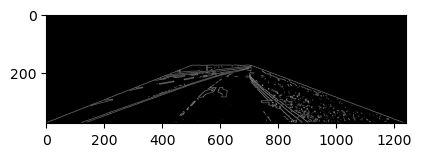

In [91]:
image = cv2.imread('carretera6.png')

cropped_image = mascara(image)
blur = kernel_gaussiano(cropped_image)

gradiente, gradienteAng = Gradientes(blur)
gradienteS = supresionM(gradiente, gradienteAng)

umbral_bajo = 50
umbral_alto = 150
bordes_fuertes, bordes_debiles = umbralizacion_histeresis(gradienteS, umbral_bajo, umbral_alto)

imagen_binaria = np.where(bordes_debiles > 0, 1, 0)

plt.subplot(3, 1, 2)
plt.imshow(imagen_binaria, cmap='gray')

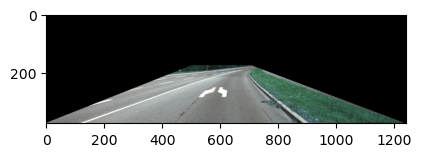

In [103]:
plt.subplot(3, 1, 2)
plt.imshow(cropped_image)

In [92]:
print(imagen_binaria.dtype)  # Should print "uint8" for 8-bit image
print(imagen_binaria.shape)

int32
(375, 1242)


In [93]:
imagen_binaria = imagen_binaria.astype(np.uint8)

In [94]:
def houghLine(image):
   Ny = image.shape[0]
   Nx = image.shape[1]

   #Max diatance is diagonal one 
   Maxdist = int(np.round(np.sqrt(Nx**2 + Ny ** 2)))
   thetas = np.deg2rad(np.arange(-180, 180))
   #Range of radius
   rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist)
   accumulator = np.zeros((2 * Maxdist, len(thetas)))
   for y in range(Ny):
      for x in range(Nx):
         # Check if it is an edge pixel
         #  NB: y -> rows , x -> columns
         if image[y,x] > 0:
            for k in range(len(thetas)):
               r = x*np.cos(thetas[k]) + y * np.sin(thetas[k])
               accumulator[int(r) + Maxdist,k] += 1
   return accumulator, thetas, rs

In [95]:

def find_lines(accumulator, threshold, rs, thetas, image):
    # Find peaks in the accumulator
    peaks = np.where(accumulator > threshold)
    lines = []
    for rho_idx, theta_idx in zip(peaks[0], peaks[1]):
        rho = rs[rho_idx]
        theta = thetas[theta_idx]
        
        # Convert polar coordinates (rho, theta) to Cartesian coordinates (x, y)
        x1 = int(rho * np.cos(theta))
        y1 = int(rho * np.sin(theta))
        x2 = int(x1 + 1000 * (-np.sin(theta)))  # Extend the line for visualization
        y2 = int(y1 + 1000 * (np.cos(theta)))  # Extend the line for visualization
        
        lines.append(((x1, y1), (x2, y2)))
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
    return lines, image

In [96]:
Oimage=image
accumulator, thetas, rhos = houghLine(imagen_binaria)
threshold = 170  # Adjust the threshold as needed
detected_lines, Oimage = find_lines(accumulator, threshold, rhos, thetas, Oimage)
print(detected_lines)

[((135, 372), (1074, 29)), ((127, 369), (1072, 43)), ((26, 254), (1020, 149)), ((26, 255), (-968, 359)), ((127, 370), (-818, 695)), ((136, 373), (-803, 715))]


In [97]:
cv2.imshow('Detected Lines', Oimage)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [98]:
def houghLine(image):
   Ny = image.shape[0]
   Nx = image.shape[1]

   #Max diatance is diagonal one 
   Maxdist = int(np.round(np.sqrt(Nx**2 + Ny ** 2)))
   thetas = np.deg2rad(np.arange(-180, 180))
   #Range of radius
   rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist)
   accumulator = np.zeros((2 * Maxdist, len(thetas)))
   for y in range(Ny):
      for x in range(Nx):
         # Check if it is an edge pixel
         #  NB: y -> rows , x -> columns
         if image[y,x] > 0:
            for k in range(len(thetas)):
               r = x*np.cos(thetas[k]) + y * np.sin(thetas[k])
               accumulator[int(r) + Maxdist,k] += 1
   return accumulator, thetas, rs

In [99]:
import cv2 as cv
import numpy as np

img = cv.imread('carretera2.png', cv.IMREAD_COLOR)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)

# Detect circles
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, .6, 60, param1=150, param2=40, minRadius=0, maxRadius=0)

if circles is not None:
    circles = np.uint16(np.around(circles))

    for c in circles[0, :]:
        # Draw the circle
        center = (c[0], c[1])
        radius = c[2]
        cv.circle(img, center, radius, (0, 255, 0), 2)

    cv.imshow('Detected Circles', img)
    cv.waitKey(0)
    cv.destroyAllWindows()
else:
    print("No circles detected.")


In [100]:
import cv2 as cv
import numpy as np

# Cargar la imagen
img = cv.imread('carretera6.png', cv.IMREAD_COLOR)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray = cv.medianBlur(gray, 5)

lines_p = []

# Convertir líneas a formato HoughLinesP
if detected_lines is not None:
    for line in detected_lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        lines_p.append([[x1, y1, x2, y2]])

# Convertir a un formato numpy array
lines_p = np.array(lines_p)

# Detectar círculos
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, .6, 60, param1=150, param2=40, minRadius=0, maxRadius=0)

# Dibujar líneas
if lines_p is not None:
    for line in lines_p:
        x1, y1, x2, y2 = line[0]
        cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Dibujar círculos
if circles is not None:
    circles = np.uint16(np.around(circles))
    for c in circles[0, :]:
        center = (c[0], c[1])
        radius = c[2]
        cv.circle(img, center, radius, (0, 255, 0), 2)

# Mostrar la imagen con líneas y círculos detectados
cv.imshow('Detected Lines and Circles', img)
cv.waitKey(0)
cv.destroyAllWindows()



In [101]:
import numpy as np

def hough_lines_p(image, rho_res=1, theta_res=np.pi/180, threshold=50, min_line_length=100, max_line_gap=10):
    # Inicializar listas para almacenar segmentos de líneas
    lines = []
    # Convertir la lista de líneas a un formato numpy array
    lines = np.array(lines)

    # Filtrar líneas basadas en el umbral de detección
    filtered_lines = lines[np.abs(lines[:, 0]) > threshold]

    # Inicializar una lista para almacenar los segmentos de líneas
    line_segments = []

    # Encontrar segmentos de líneas a partir de las líneas detectadas
    for rho_val, theta_val in filtered_lines:
        a = np.cos(theta_val)
        b = np.sin(theta_val)
        x0 = a * rho_val
        y0 = b * rho_val
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        if length >= min_line_length:
            line_segments.append([(x1, y1), (x2, y2)])

    return line_segments



In [102]:
import cv2

# Cargar la imagen
image = cv2.imread('carretera2.png', cv2.IMREAD_GRAYSCALE)

# Llamar a la función para detectar segmentos de líneas
segments = hough_lines_p(imagen_binaria)

# Dibujar los segmentos de líneas en la imagen original
for segment in segments:
    cv2.line(image, segment[0], segment[1], (0, 0, 255), 2)

# Mostrar la imagen con los segmentos de líneas detectados
cv2.imshow('Líneas Detectadas', image)
cv2.waitKey(0)
cv2.destroyAllWindows()